# Chapter 3.3 - Classify images with CNNs

* *Summary: End-to-end implementation and thought process for training a CNN to classify images*
* *Duration: ~10 minutes (with NVIDIA 1080 Ti GPU)*
* *Video: - (to be announced)*
* *Slides: - (to be announced)*

***

In the last couple of years CNNs have been widely used both in research as in industry. The breaktrough of Convolutional Neural Networks was initiated by a number of research papers that outperformed human accuracy in the well known image competition ILSVRC (ImageNet Large-Scale Visual Recognition Challenge). In the competition, algorithms are scored for image classification and object detection at a large scale.

CNNs are currently widely used in both research as real-world applications. This notebook will guide you through the steps of building a CNN for a image classification task. For this, we will use the MNIST dataset. In Chapter 2 we already introduced the MNIST dataset: a grayscale dataset with handwritten digits in the range from 0 to 9. With our neural network we were able to classify the images with 97.3% accuracy. In this notebook we will demonstate how a simple convolutional network can get an above-human accuracy of 99.4%.

## What will we do?
Classify handwritten digits (MNIST dataset) with a Convolutional Neural Network (CNN). In this notebook we pay special attention to guide you through the thought process for using a CNN to classify images. **_No assumptions are made._** Therefore, EDA, model selection, and hyperparameter tuning are all included separately. This to make sure you understand each design choice made and help you when applying CNNs to your own projects.

## What do I need ([installation guide](https://github.com/indradenbakker/Introduction-to-Deep-Learning-with-Gluon))?
* MXNet 1.0
* NumPy & Matplotlib
* Python 3.6
* GPU (recommended)

---

## Code example

#### 1. We start with importing Gluon and all dependencies needed to run the code in this notebook. In addition we set the seed for reproducability:

In [44]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import nd, autograd, gluon
mx.random.seed(1)

#### 2. In this notebook we enable GPU usage by using the following line to set the context. If you don't have a GPU, you can replace '`gpu`' with '`cpu`'.

In [104]:
ctx = mx.cpu() # mx.cpu()

#### 3. The load the MNIST dataset we can use '`test_utils`' from MXNet as follows:

In [25]:
from mxnet.test_utils import get_mnist
data = get_mnist()

Note: In many code examples for CNNs and the MNIST dataset one of the first steps is to load the MNIST dataset with a batch generator. This is done without any exploratory data analysis. This is highly unlikely to do in a real-world scenario. In this notebook we will follow the general steps without any assumptions, so that one can use this path for other problems.

For other datasets you probably cannot use '`test_utils`'. Therefore, you can find code to load the raw MNIST dataset [here](https://github.com/indradenbakker/Introduction-to-Deep-Learning-with-Gluon).

#### 4. To give us an idea of how the dataset looks like, let's plot some statistics:

In [101]:
print('Training data shape: {}'.format(data['train_data'].shape))
print('Training data labels: {}'.format(data['train_label'].shape))
print('Test data shape: {}'.format(data['test_data'].shape))
print('Test data labels: {}'.format(data['test_label'].shape))
print('Number of unique labels in training set: {}'.format(len(set(data['train_label']))))

# We randomly pick an example from the training set for some simple statistics
data_example = data['train_data'][np.random.randint(0, len(data['train_data']))]
print('\nTraining example: min: {}, max: {}, mean: {:0.4f}'
      .format(data_example.min(), data_example.max(), data_example.mean()))

Training data shape: (60000, 1, 28, 28)
Training data labels: (60000,)
Test data shape: (10000, 1, 28, 28)
Test data labels: (10000,)
Number of unique labels in training set: 10

Training example: min: 0.0, max: 1.0, mean: 0.1681


What we learn from the above output is:
* we have 60K training images and 10K test images
* each datapoint (image) has a 3D-shape: (channel, width, height)
* the images have shape 28x28
* our images are in grayscale, so as expected we only have 1 channel
* the image pixels are normalized and scaled: [0, 1]

#### 5. We can also output a random example of each handwritten digit and their count:

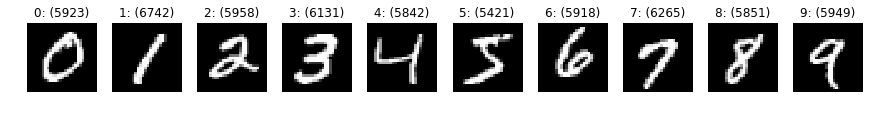

In [105]:
X_train = data['train_data']
y_train = data['train_label']

# Plot first image of each label
unique_labels = set(data['train_label'])
n_labels = len(unique_labels)
plt.figure(figsize=(15, 15))
i = 1
for label in unique_labels:
    image = X_train[y_train.tolist().index(label)]
    plt.subplot(n_labels, n_labels, i)
    plt.axis('off')
    plt.title("{0}: ({1})".format(label, y_train.tolist().count(label)))
    i += 1
    # To plot grayscale images with Matplotlib 2D-arrays are expected
    # So we use image[0] to create a 2D-array from the (1, w, h) format.
    _ = plt.imshow(image[0], cmap='gray')
plt.show()

As we can see the data is almost evenly distributed. Therefore, we will keep the dataset as is and we won't be using any preprocessing steps.

#### 5. To evaluate our model during training we need to write a function. This function needs to iterate through the data and return the accuracy. As input, we will have a dataset iterator and the trained network.

MXNet has a [Evaluation Metric API](https://mxnet.incubator.apache.org/api/python/metric.html) that includes all frequently used metrics, like accuracy and RMSE. 

In step x, we will show you how to set the data iterator. 

In [ ]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

#### 6. After a quick look at the training data we can start building our CNN.

In [102]:
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Conv2D(channels=32, kernel_size=5, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))            
    net.add(gluon.nn.Conv2D(channels=64, kernel_size=5, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))

    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(512, activation="relu"))
    net.add(gluon.nn.Dense(n_labels))

We start with a simple network architecture where we use 2 convolutional blocks with increasing number of channels. 

After the convolutional blocks, we flatten the output and feed the data to a fully connected layer with 512 units. 

We are trying to create a model to classify the handwritten digits. We have 10 unique labels in our training set, so our final layer should contain 10 units (1 for each label). 

#### 6. As explained in Chapter 2, the initialisation of the weights can be important. For our network, we use the popular [Xavier initialisation](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf). In addtion, we use the defined context '`ctx`' to make sure the weights are placed on the GPU as well.

In [103]:
net.collect_params().initialize(mx.init.Xavier(), ctx=ctx) #magnitude=2.24

#### 7. Next, we need to define the loss function that we will use during training. For our multiclass classification problem, the Softmax cross-entropy loss is the logical choice. Softmax cross-entropy measures the probability error in a discrete classification tasks, where each training example only belongs to 1 class (the classes are mutually exclusive).

In [12]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

#### 9. We will be using the Adam optimizer to train our network. Adam is a great choice, if you're just starting and have no idea which hyperparameters to use. It will give you a great benchmark to build upon further in a later stage.

In [110]:
trainer = gluon.Trainer(net.collect_params(), 'adam') #'sgd', {'learning_rate': .1})

#### We can now define the hyperparameters. We start with a relative low number of epochs, so that we can quickly see if our model is able to train correctly. 

In [113]:
n_epochs = 4
smoothing = .01
batch_size = 64

#### Instead of the loaded MNIST dataset, we will be using [Gluon dataset API](https://mxnet.incubator.apache.org/api/python/gluon/data.html)'s DataLoader to load and transform the data in batches while feeding the data to our network. First, we delete the loaded dataset to clean up the memory.

In [115]:
# del data, data_example
# num_inputs = 784
# num_outputs = 10
def transform(data, label):
    return nd.transpose(data.astype(np.float32), (2,0,1)), label.astype(np.float32)
train_data = gluon.data.DataLoader(gluon.data.vision.MNIST(train=True, transform=transform),
                                      batch_size, shuffle=True)
test_data = gluon.data.DataLoader(gluon.data.vision.MNIST(train=False, transform=transform),
                                     batch_size, shuffle=False)

#### We are now ready to start training our model for the first time. 

In [116]:
for e in range(n_epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(data.shape[0])        
        curr_loss = nd.mean(loss).asscalar()
        
    test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, curr_loss, train_accuracy, test_accuracy))

Epoch 0. Loss: 0.0839653457669, Train_acc 0.985183333333, Test_acc 0.9815
Epoch 1. Loss: 0.0626324687575, Train_acc 0.988, Test_acc 0.9824
Epoch 2. Loss: 0.0514723012598, Train_acc 0.9873, Test_acc 0.981
Epoch 3. Loss: 0.0398709181185, Train_acc 0.99235, Test_acc 0.9875


Great! In just 4 epochs we were able to get a validation accuracy of 98.75%. This gives us confidence that our implementation works correctly and we can build further. 

What we see is the following:
* Train accuracy is already 99.24% and by training our model for more epochs we can probably push the training accuracy further. 
* The validation accuracy stays a little bit behind: the difference in the 4th epoch is 0.485%. It's not a lot, but it can be a sign of overfitting on the training set. However, it's too soon to draw any conclusions. 

#### Let's implement early stopping to prevent overfitting on the training data and run our algorithm for more epochs.

In [238]:
class earlyStopping():
    def __init__(self, patience = 5, epoch_start = 0, best_loss = 1e100, minimize = True):
        self.patience = patience
        self.best_loss = best_loss if minimize else -best_loss
        self.step = epoch_start
        
    def early_stopping(self, loss, e):
        if (loss < self.best_loss):
            self.step = 0
            self.best_loss = loss
        else:
            self.step += 1
        if self.step >= self.patience:
            print("Early stopping after {} epochs with best loss {}".format(e, self.best_loss))
            return True
        else: 
            return False

#### We can now run our model with a callback for early stopping as follows:

In [237]:
stop = False
cb = earlyStopping(patience = 2)
e = 1

while stop == False:
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(data.shape[0], )        
        curr_loss = nd.mean(loss).asscalar()
        
    test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    print("Epoch {}. Loss: {}, Train_acc {}, Test_acc {}".format(e, curr_loss, train_accuracy, test_accuracy))
    stop = ES.early_stopping(curr_loss, e)
    e += 1

Epoch 1. Loss: 0.00268501, Train_acc 0.991633333333, Test_acc 0.9833
Epoch 2. Loss: 0.00401691, Train_acc 0.99405, Test_acc 0.988
Epoch 3. Loss: 0.0121798, Train_acc 0.986733333333, Test_acc 0.9804
Early stopping after 3 epochs with loss 0.012179761193692684
Epoch 4. Loss: 0.000267027, Train_acc 0.9899, Test_acc 0.9839


KeyboardInterrupt: 